In [ ]:
#%%
# preprocessing data
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd

# import dataset
dataset = pd.read_csv('/content/drive/MyDrive/ToN_IoT/Train_Test_Network.csv')

#%%
y = dataset.label.to_frame()
features = [c for c in dataset.columns if (c != "label") and (c != "type")]
X = dataset[features]

# delete irrelevant features
list_delete = ['ts', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto']
X = X.drop(columns = list_delete)

#%%
# label encoding data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

list_encode = ['service', 'conn_state', 'dns_query', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 
               'ssl_version',  'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 
               'ssl_issuer', 'http_method', 'http_uri', 'http_version', 'http_user_agent' , 
               'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', 'weird_addl',
               'weird_notice', 'http_trans_depth']

for i in list_encode:
    X[i] = le.fit_transform(X[i])
    
#%%    
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

#%%
# feature scaling
from sklearn.preprocessing import Normalizer
scaler = Normalizer()

X_train.iloc[:,:] = scaler.fit_transform(X_train.to_numpy())
X_test.iloc[:,:] = scaler.transform(X_test.to_numpy())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%%
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model 
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# predict test set resutl and make confusion matrix
y_pred = loaded_model.predict(X_test)
y_pred_binary = (y_pred > 0.5)
from sklearn.metrics import confusion_matrix

def get_confusion_matrix_values(z_true, z_pred):
    cm = confusion_matrix(z_true, z_pred)
    return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

TP, FP, FN, TN = get_confusion_matrix_values(y_test, y_pred_binary)
detection_rate = TP/(TP+FN)
false_alarm_rate = FP/(TN+FP)
accuracy = (TP+TN)/(TP+FP+TN+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = (2*precision*recall)/(precision + recall)

print("\n Detection rate = ", detection_rate, "\n")
print("False alarm rate = ", false_alarm_rate, "\n")
print("Accuracy = ", accuracy, "\n")
print("Precision = ", precision, "\n")
print("Recall = ", recall, "\n")
print("F1 = ", F1, "\n")

Loaded model from disk

 Detection rate =  0.9584687195896353 

False alarm rate =  0.05433818872704243 

Accuracy =  0.9540825732846034 

Precision =  0.9713172982098384 

Recall =  0.9584687195896353 

F1 =  0.9648502357707378 



In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import accuracy_score

def score(self, X, y, sample_weight=None):
      return accuracy_score(y, self.predict(X)>0.5, sample_weight=sample_weight)

perm = PermutationImportance(loaded_model, score, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

     |████████████████████████████████| 112kB 14.3MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.3322 ± 0.0015,dns_query
0.2129 ± 0.0018,src_ip_bytes
0.1343 ± 0.0013,dst_bytes
0.1251 ± 0.0008,conn_state
0.1229 ± 0.0016,dst_ip_bytes
0.1182 ± 0.0016,src_bytes
0.0654 ± 0.0014,src_pkts
0.0599 ± 0.0009,dst_pkts
0.0133 ± 0.0010,dns_qtype
0.0059 ± 0.0006,duration


     |████████████████████████████████| 34.0MB 137kB/s 
     |████████████████████████████████| 13.1MB 46.4MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758228 sha256=efe3fc1128581be739605dc25ddabc0501b49aa80805ae0b9cd267b358b3c22f
  Stored in directory: /root/.cache/pip/wheels/c8/13/11/ecac74c6192790c94f6f5d919f1a388f927b9febb690e45eef
Successfully built pdpbox
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


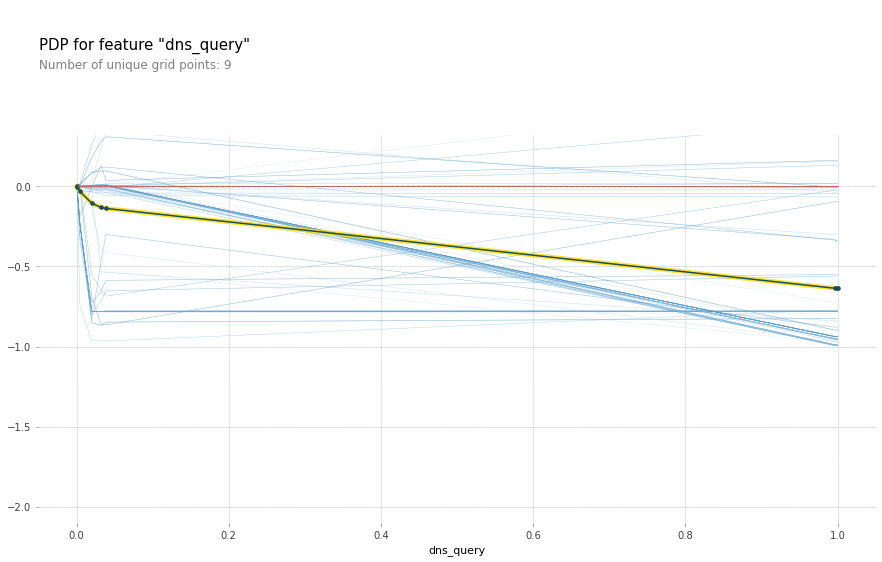

In [ ]:
from matplotlib import pyplot as plt
!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

feature_name = "dns_query"
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=loaded_model, dataset=X_test, model_features=X_test.columns, feature=feature_name)

# plot it
pdp.pdp_plot(pdp_goals, feature_name, plot_lines=True, frac_to_plot=100)
plt.show()

     |████████████████████████████████| 358kB 16.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491628 sha256=86a2781c03fc9b3c6cf08e8f075e8096311d9bb9342e83bcbb3c17a7d6dcd62f
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


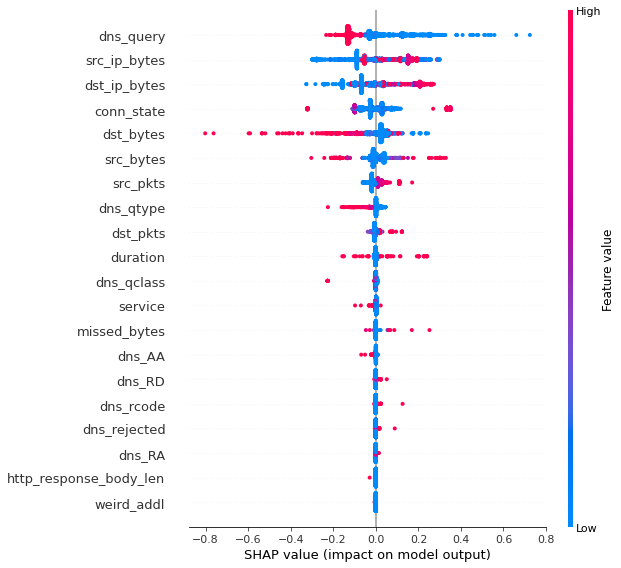

In [ ]:
#%%
!pip install shap
import shap
import pandas as pd 

sample = X_test.iloc[:2000]
 
explainer = shap.DeepExplainer(loaded_model, np.array(sample))
shap_values = explainer.shap_values(np.array(sample))

shap.initjs()
#shap.force_plot(explainer.expected_value[0].numpy().tolist(), shap_values[0], sample)
shap.summary_plot(shap_values[0], sample)

In [ ]:
#%%
import shap  # package used to calculate Shap values

index = 100
row_to_show = X_test.iloc[index:index+1]
print(loaded_model.predict(row_to_show))
shap_values = explainer.shap_values(np.array(row_to_show))
print('shap_values: ', shap_values[0])
print('explainer ', explainer.expected_value[0].numpy().tolist())
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy().tolist(), shap_values[0], row_to_show) 

[[4.169584e-06]]
shap_values:  [[ 3.61391481e-04 -2.72476390e-03 -5.95834359e-03  4.55986530e-02
  -4.58750491e-02 -6.19615029e-05 -2.48376566e-02 -5.10870433e-02
  -1.06204340e-02 -8.69775256e-02 -1.24568071e-01 -1.35291349e-04
  -2.73830509e-02 -5.15822489e-04 -3.65434250e-04 -2.93113420e-06
   9.98090940e-05  3.86748740e-06 -5.56350819e-09 -5.44597459e-09
   2.50438951e-09  1.72054416e-09  0.00000000e+00  0.00000000e+00
   8.10977806e-09  5.71976236e-10  2.12911651e-08  1.09614120e-09
   0.00000000e+00  2.89927013e-06  1.82343339e-07  1.69431538e-08
   0.00000000e+00  2.78544304e-11  3.51677329e-10  1.04653862e-09
   4.02550980e-10]]
explainer  0.33505067229270935
